In [2]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torchaudio
import os
import glob
from torch.utils.data import Dataset, DataLoader
import random
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import config

ModuleNotFoundError: No module named 'config'

In [4]:
class MyPipeline(torch.nn.Module):
    def __init__(
        self,
        input_freq,
        resample_freq,
        device,
        n_fft=2048,
        hop_length = 512,
        n_mels=80,  
        win_length = 2048,
        window = 'hann',
        desired_length_in_seconds=5,
        train=True,
    ):
        super().__init__()
        
        self.train = train
        self.desired_length_in_seconds = desired_length_in_seconds
        self.sample_rate = 32000
        self.mel_spectrogram = T.MelSpectrogram(
        sample_rate=32000,  # Your sample rate
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        win_length=win_length,
        window_fn=torch.hann_window  # This corresponds to the 'hann' window
        ).to(device)

        self.PS = T.PitchShift(self.sample_rate, n_steps=1.1).to(device)
        
        self.amplitude = T.AmplitudeToDB().to(device)

        self.spec_aug = torch.nn.Sequential(
            T.TimeStretch(random.uniform(0.8, 1.2), fixed_rate=True).to(device),
            T.FrequencyMasking(freq_mask_param=15).to(device),
            T.TimeMasking(time_mask_param=90).to(device),
        )

    @staticmethod
    def random_crop_or_pad(waveform, sample_rate, desired_length_in_seconds=5):
            """
            Randomly crops the waveform to the desired length in seconds.
            If the waveform is shorter than the desired length, it will be padded with zeros.
            """
            desired_length = desired_length_in_seconds * sample_rate
            current_length = waveform.shape[1]

            # If the waveform is shorter than desired, pad it with zeros
            side = random.randint(0,2)

            if current_length < desired_length:
                if side == 0:
                    padding_needed = desired_length - current_length
                    left_pad = padding_needed // 2
                    right_pad = padding_needed - left_pad
                    waveform = torch.nn.functional.pad(waveform, (left_pad, right_pad))
                elif side == 1:
                    padding_needed = desired_length - current_length
                    left_pad = padding_needed
                    right_pad = 0
                    waveform = torch.nn.functional.pad(waveform, (left_pad, right_pad))
                else:
                    padding_needed = desired_length - current_length
                    left_pad = 0
                    right_pad = padding_needed
                    waveform = torch.nn.functional.pad(waveform, (left_pad, right_pad))
            
            # Calculate the starting point for cropping
            start_idx = random.randint(0, waveform.shape[1] - desired_length)
            return waveform[:, start_idx:start_idx+desired_length]

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        
        # Apply pitch shift
        #waveform = self.PS(waveform)

        #crop or pad
        waveform = self.random_crop_or_pad(waveform, 32000, self.desired_length_in_seconds)

        # Convert to power spectrogram
        spec = self.mel_spectrogram(waveform)

        # Apply SpecAugment
        if self.train: spec = self.spec_aug(spec)
        
        # Convert to decibel
        spec = self.amplitude(spec).squeeze(0)


        if config.channels == 3:
            spec = torch.stack([spec, spec, spec]) 

        return spec

In [ ]:
labels_file = pd.read_csv('./data/labeled_ADSMI/labels_int.csv', index_col=0)
labels_file = labels_file.drop(columns=['fold'])
labels_file







,filename,Label_int,Label
0,2014-06-17_09-20-53_01.WAV,0,[Kreischen]
1,2014-05-27_16-38-25_01.WAV,0,[Kreischen]
2,2014-07-10_06-30-19_01.WAV,0,[Kreischen]
3,2014-07-02_11-20-06_01.WAV,0,[Kreischen]
4,2014-07-18_18-04-16_01.WAV,2,[Negativ]
...,...,...,...
4715,2014-06-18_03-16-04_01.WAV,0,[Kreischen]
4716,2014-06-20_21-36-02_01.WAV,0,[Kreischen]
4717,2014-09-19_02-16-42_01.WAV,1,[Kreischen][Quietschen]
4718,2014-07-01_09-35-19_01.WAV,2,[Negativ]


In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold



In [ ]:
labels_file = pd.read_csv('./data/labeled_ADSMI/labels_int.csv', index_col=0)

class MyDataset_finetune(Dataset,):
    
    def __init__(self, train=True,sample_rate=32000, desired_length_in_seconds=10):
        self.root = './data/labeled_ADSMI/labeled_data_2013-535/'
        self.train = train
        
        #getting name of all files inside the all of the train_folds
        temp = os.listdir(self.root)
        temp.sort()
        self.file_names = []
        self.class_ids = []
        if self.train:
            for i in range(len(labels_file["Label_int"])):
                if int(labels_file["fold"][i]) in config.ADSMI_train_folds:
                    self.file_names.append(labels_file["filename"][i])
                    self.class_ids.append(labels_file["Label_int"][i])
        else:
            for i in range(len(labels_file["Label_int"])):
                if int(labels_file["fold"][i]) in config.ADSMI_test_fold:
                    self.file_names.append(labels_file["filename"][i])
                    self.class_ids.append(labels_file["Label_int"][i])

        
        if self.train:
            self.pipeline = MyPipeline(sample_rate, sample_rate, 'cuda', desired_length_in_seconds=desired_length_in_seconds, train=self.train)
            self.pipeline.to(device=torch.device("cuda"), dtype=torch.float32)

        
        else: #for test
            self.pipeline = MyPipeline(sample_rate, sample_rate, 'cuda', desired_length_in_seconds=desired_length_in_seconds, train=self.train)
            self.pipeline.to(device=torch.device("cuda"), dtype=torch.float32)    
    
    def __len__(self):
        return len(self.file_names)
    


    def __getitem__(self, index):
        file_name = self.file_names[index]  
        path = self.root + file_name
        
        # Using torchaudio to load waveform
        waveform, sample_rate = torchaudio.load(path)
        waveform = waveform.to(device=torch.device("cuda"), dtype=torch.float32)

        mel_spec = self.pipeline(waveform)

        class_id = self.class_ids[index]

        return mel_spec, class_id

def create_generators_finetune():
    train_dataset = MyDataset_finetune(train=True, desired_length_in_seconds=config.desired_length_in_seconds)
    test_dataset = MyDataset_finetune(train=False, desired_length_in_seconds=config.desired_length_in_seconds)
    

    train_loader = DataLoader(train_dataset, batch_size = config.batch_size, shuffle=True, num_workers=0 ,drop_last=False)
    
    test_loader = DataLoader(test_dataset, batch_size = config.batch_size, shuffle=True, num_workers=0 ,drop_last=False)
    
    return train_loader, test_loader

c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


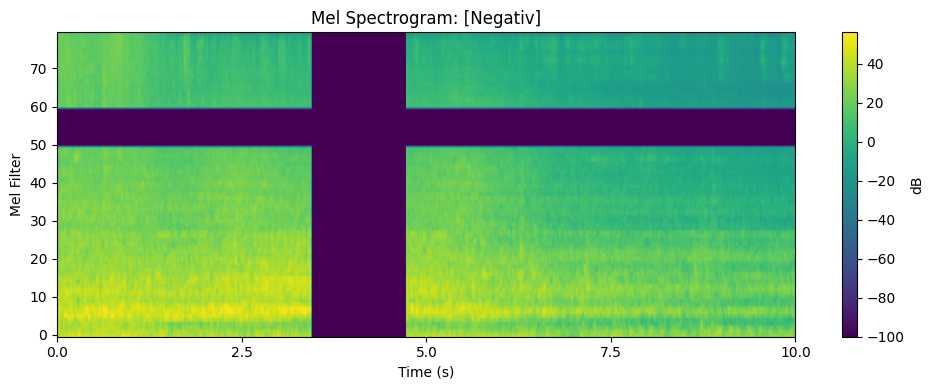

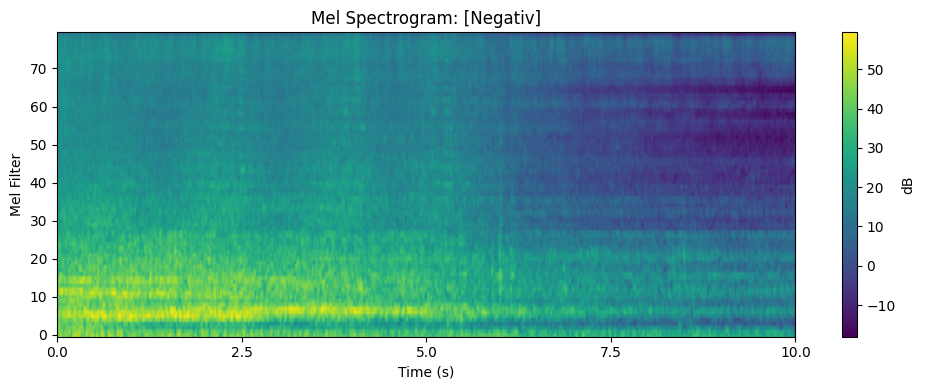

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_first_spectrogram(train_loader):
    hop_length = 512
    sample_rate = 32000
    
    # Define the label dictionary
    true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}
    
    # Retrieve first batch
    spectrograms, labels = next(iter(train_loader))
    
    # Take the first spectrogram and average across channels
    spectrogram = spectrograms[0].mean(dim=0).squeeze().cpu().detach().numpy()
    
    # Display the spectrogram
    plt.figure(figsize=(10, 4))  # Adjust the figure size as needed
    plt.imshow(spectrogram, cmap='viridis', origin='lower', aspect='auto')

    # Setting labels and title
    plt.ylabel('Mel Filter')
    plt.xlabel('Time (s)')
    plt.colorbar(label='dB')
    plt.title(f'Mel Spectrogram: {true_labels_dic[int(labels[0])]}')

    # Calculate time axis in seconds
    num_time_bins = spectrogram.shape[1]
    time_in_seconds = np.arange(0, num_time_bins) * hop_length / sample_rate

    # Adjust x-axis to show time in seconds
    x_ticks = np.linspace(0, num_time_bins, 5)
    x_labels = [f"{t:.1f}" for t in np.linspace(0, time_in_seconds[-1], 5)]
    plt.xticks(x_ticks, x_labels)

    plt.tight_layout()
    plt.show()

# Create the data loaders
train_loader, test_loader = create_generators_finetune()  # Make sure you have this function defined

# Visualize the first spectrogram
visualize_first_spectrogram(train_loader)
visualize_first_spectrogram(test_loader)

In [ ]:
print(config.channels)

class Resnet50_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Resnet50_Classifier, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)

3


In [ ]:
class ResNet101_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet101_Classifier, self).__init__()
        self.resnet101 = models.resnet101(pretrained=True)
        # Modify the input layer to match your input data channels
        # If your input data has different channels, adjust this line accordingly
        self.resnet101.conv1 = nn.Conv2d(config.channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_features = self.resnet101.fc.in_features
        self.resnet101.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet101(x)

In [ ]:
class ModifiedResnet50_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResnet50_Classifier, self).__init__()
        
        # Load the pretrained ResNet-50 model
        self.resnet50 = models.resnet50(pretrained=True)
        
        # Modify the first convolutional layer
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Remove the final fully connected layer
        self.resnet50.fc = nn.Identity()  # Set the final layer to an identity mapping
        
        # Define the custom fully connected layers
        num_features = 2048 
        self.fc1 = nn.Linear(num_features, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.resnet50(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
train_loader, test_loader = create_generators_finetune( )

#  Create an instance of the model
num_classes = len(set(labels_file["Label_int"]))  # Assuming the number of classes is the unique count of "Label_int" in your labels_file
model = Resnet50_Classifier(num_classes)
#model = ModifiedResnet50_Classifier(num_classes)
#model = ResNet101_Classifier(num_classes)



#  Transfer the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004, weight_decay = 1e-4 ) # Adjust the value as needed)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.8, verbose=True)

train_losses = []
test_losses = []
config.best_accuracy = 0
config.model_path = "./results_standalone/test_re1Layer_checkpoint.pth"
# Training loop
num_epochs = 100  # Adjust this as needed
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (spectrograms, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)
        train_losses.append(loss.item())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



    correct_predictions = 0
    total_samples = 0

    # Set the model to evaluation mode (important for dropout and batch normalization)
    model.eval()

    # Iterate through the test set
    with torch.no_grad():  # Disable gradient computation during testing
        for spectrograms, labels in test_loader:
            # Move data to the testing device
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())
            
            # Compute the predicted labels
            _, predicted = torch.max(outputs, 1)

            # Update evaluation metrics
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    #if new test accuracy is better than the previous best, save the model
    if correct_predictions / total_samples > config.best_accuracy:
        config.best_accuracy = correct_predictions / total_samples
        torch.save(model, config.model_path)
        
    # Step the learning rate scheduler
    scheduler.step(test_losses[-1])

    # Calculate accuracy or other evaluation metrics
    accuracy = correct_predictions / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    print(f"Test Accuracy: {accuracy * 100:.2f}%")



c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 25%|██▍       | 16/65 [00:09<00:28,  1.72it/s]

c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Balanced Accuracy: 87.31%
Test Accuracy: 91.36%

Evaluation Results:
Accuracy: 91.36%
Precision: 91.38%
Recall: 91.36%


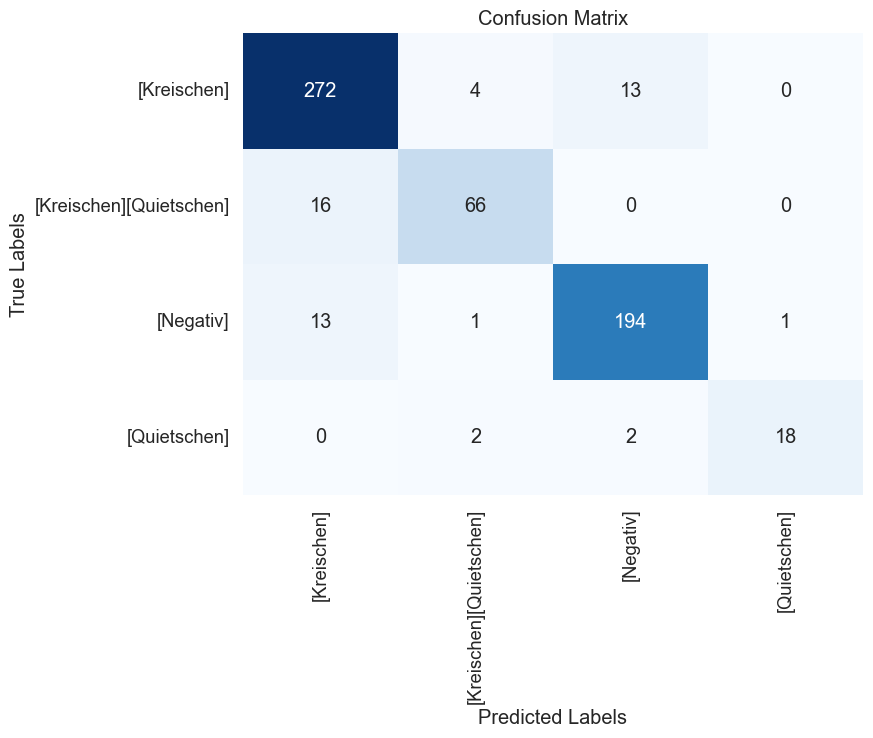

In [ ]:
import torch
import torch.nn as nn
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
# Assuming you have already defined your model architecture
# and loaded any pre-trained weights, e.g., model = Resnet50_Classifier(num_classes)

# Set the device for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a data loader for the test set
_,test_loader = create_generators_finetune()  # Assuming create_generators_finetune returns (train_loader, test_loader)


model = torch.load(config.model_path)
# Transfer the model to the testing device
model.to(device)

# Define a criterion for evaluation (e.g., cross-entropy loss for classification)
criterion = nn.CrossEntropyLoss()

# Initialize variables for evaluation metrics (e.g., accuracy)
correct_predictions = 0
total_samples = 0

# Define the label dictionary
true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# Set the model to evaluation mode (important for dropout and batch normalization)
model.eval()

# Initialize lists to store all true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Iterate through the test set
with torch.no_grad():
    for spectrograms, labels in test_loader:
        # Move data to the testing device
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        
        # Compute the predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels to the lists
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
accuracy = np.mean(all_true_labels == all_predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')
_, recall_per_class, _, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels)



#calculate balanced accuracy
balanced_accuracy = np.mean(recall_per_class)
print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
def plot_confusion_matrix(conf_mat, class_labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    
    # Convert class_labels to a list of strings (or integers)
    class_labels = [str(label) for label in class_labels]
    
    ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)  # Rotate x-axis labels vertically
    plt.show()

plot_confusion_matrix(conf_mat, true_labels_dic.values())



In [ ]:
recall[1]

IndexError: invalid index to scalar variable.

In [ ]:
# Create the pipeline
pipeline = MyPipeline(32000, 32000, 'cuda', desired_length_in_seconds=config.desired_length_in_seconds, train=True)
pipeline.to(device=torch.device("cuda"), dtype=torch.float32)
i=1

# Use the pipeline on the first file in the dataset
file_name = os.listdir("./data/labeled_ADSMI/labeled_data_2013-535")[i]
path = os.path.join("./data/labeled_ADSMI/labeled_data_2013-535", file_name)

# Load the file
waveform, sample_rate = torchaudio.load(path)
print("length in seconds: ", len(waveform[0]) / sample_rate)
waveform = waveform.to(device=torch.device("cuda"), dtype=torch.float32)
mel_spec = pipeline(waveform)

def plot_mel_spectrogram(melspe_db, sample_rate, hop_length):
    plt.figure(figsize=(10, 4))

    # Convert tensor data to numpy for visualization
    melspe_db_np = melspe_db[0].squeeze().cpu().numpy()

    # Display the spectrogram
    plt.imshow(melspe_db_np, cmap='viridis', origin='lower', aspect='auto')

    # Setting labels and title
    plt.ylabel('Mel Filter')
    plt.xlabel('Time (s)')
    plt.colorbar(label='dB')
    plt.title('Mel Spectrogram')

    # Adjust x-axis to show time in seconds
    num_time_bins = melspe_db_np.shape[1]
    plt.xticks(np.linspace(0, num_time_bins, 5), np.linspace(0, num_time_bins * hop_length / sample_rate, 5))

    plt.tight_layout()
    plt.show()

# Set the hop length (change this if you specified a different value when computing the spectrogram)
 # Default in torchaudio
plot_mel_spectrogram(mel_spec, sample_rate,hop_length=512)


mel_spec.shape

NameError: name 'MyPipeline' is not defined

In [ ]:
mel_spec.shape

torch.Size([1, 80, 626])